<a href="https://colab.research.google.com/github/davidfague/Neural-Modeling/blob/main/Soma_Axial_Currents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
is_colab = 'google.colab' in str(get_ipython())

In [2]:
if is_colab:
    !git clone https://github.com/davidfague/Neural-Modeling.git
    %cd Neural-Modeling

Cloning into 'Neural-Modeling'...
remote: Enumerating objects: 1735, done.
remote: Counting objects: 100% (646/646), done.
remote: Compressing objects: 100% (257/257), done.
remote: Total 1735 (delta 428), reused 567 (delta 379), pack-reused 1089
Receiving objects: 100% (1735/1735), 28.29 MiB | 27.40 MiB/s, done.
Resolving deltas: 100% (1138/1138), done.
/content/Neural-Modeling


In [3]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss
from mpl_toolkits import mplot3d
import pdb #python debugger

from Modules.segment import SegmentManager

In [4]:
if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [5]:
output_folder = 'L5PCtemplate[0]_46e-1Hz_642nseg_1500ms_108nbranch_28918NCs_28918nsyn'
dt=0.1
sm = SegmentManager(output_folder, dt = dt, skip=300)

# v = h5py.File('./{}/Vm_report.h5'.format(output_folder),'r') #read segment voltage traces

# gNaTa = h5py.File('./{}/gNaTa_T_data_report.h5'.format(output_folder),'r') #read segment voltage traces
# iampa = h5py.File('./{}/i_AMPA_report.h5'.format(output_folder),'r') #read segment voltage traces
# inmda = h5py.File('./{}/i_NMDA_report.h5'.format(output_folder),'r') #read segment voltage traces
# igaba = h5py.File('./{}/i_GABA_report.h5'.format(output_folder),'r') #read segment voltage traces
# icah = h5py.File('./{}/icah_data_report.h5'.format(output_folder),'r') #read segment voltage traces
# ical = h5py.File('./{}/ical_data_report.h5'.format(output_folder),'r') #read segment voltage traces
# ih = h5py.File('./{}/ih_data_report.h5'.format(output_folder),'r') #read segment voltage traces
# ina = h5py.File('./{}/ina_data_report.h5'.format(output_folder),'r') #read segment voltage traces


# spikes = h5py.File('./{}/spikes_report.h5'.format(output_folder),'r') #read segment voltage traces

# segs = pd.read_csv('./{}/seg_info.csv'.format(output_folder)) # read segment values

Probe class for making a segment's attributes accesible.

In [6]:
dir(sm.segments[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'adj_segs',
 'adjacent_segments',
 'axial_currents',
 'bmtk_index',
 'child_axial_currents',
 'child_segs',
 'color',
 'gNaTa',
 'iampa',
 'icah',
 'ical',
 'ih',
 'ina',
 'inmda',
 'name',
 'netcon_SA_density_per_seg',
 'netcon_density_per_seg',
 'netcons_per_seg',
 'p0_5_x3d',
 'p0_5_y3d',
 'p0_5_z3d',
 'p0_x3d',
 'p0_y3d',
 'p0_z3d',
 'p1_x3d',
 'p1_y3d',
 'p1_z3d',
 'parent_axial_currents',
 'parent_segs',
 'pseg_index',
 'sec',
 'sec_L',
 'sec_Ra',
 'sec_diam',
 'sec_index',
 'sec_nseg',
 'seg',
 'seg_L',
 'seg_SA',
 'seg_diam',
 'seg_elec_distance',
 'seg_h_distance',
 'seg_half_seg_RA',
 'seg_index_global',
 'type'

In [7]:
sm.segments[300].pseg_index

299.0

In [8]:
# #Get Columns
# for seg in sm.segments:
#   seg.sec_index = seg.sec_index.astype(int)
#   seg.x = seg.x.astype(float)

Determine which segments are next to each other.

In [9]:
# for seg in sm.segments:
#   print(seg.name, seg.adj_segs)

Compute axial currents from each segment toward its adjacent segments.

In [10]:
#compute axial currents between all segments
for seg in sm.segments:
  for adj_seg in seg.adj_segs:
    axc = (seg.v - adj_seg.v) / (seg.seg_half_seg_RA + adj_seg.seg_half_seg_RA) #compute axial current using (v_in-v_out)/(halfsegRa+halfsegRa)
    seg.axial_currents.append(axc)
    if adj_seg in seg.parent_segs:
      seg.parent_axial_currents.append(axc)
    elif adj_seg in seg.child_segs:
      seg.child_axial_currents.append(axc)

Find soma segments

In [11]:
#Find soma segments
soma_segs = []
for seg in sm.segments:
  if seg.type == 'soma':
    soma_segs.append(seg)
if len(soma_segs) != 1:
  raise(ValueError("There should be only one soma segment."))

Plot segments adjacent to soma

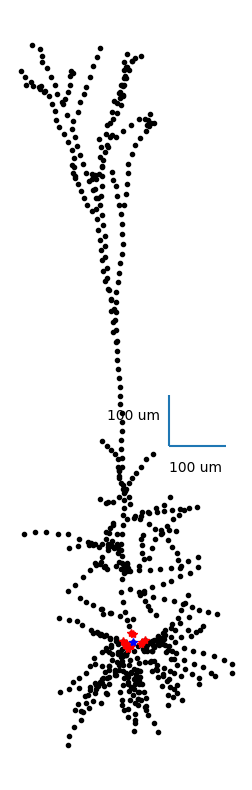

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3,10))
# Since 'segs' is now a list of segment objects instead of a dictionary, we need to iterate through it
# and get the 'p0_5_x3d' and 'p0_5_y3d' attributes of each segment
x_values = [seg.p0_5_x3d for seg in sm.segments]
y_values = [seg.p0_5_y3d for seg in sm.segments]

ax = plt.plot(x_values, y_values, '.', color='black', markersize=6)

plt.vlines(110, 400, 500)
plt.text(0, 450, '100 um')
plt.hlines(400, 110, 210)
plt.text(110, 350, '100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)

# plot segments that are adjacent to soma segments
for soma_seg in soma_segs:
    for adj_seg in soma_seg.adj_segs:
        plt.plot(adj_seg.p0_5_x3d,
                 adj_seg.p0_5_y3d,
                 '*', color='red')

# plot soma segments
for seg in soma_segs:
    plt.plot(seg.p0_5_x3d,
             seg.p0_5_y3d,
             '*', color='blue')

plt.show()

Plot Axial Currents

In [14]:
def plot_all(segment, xlim=None, ylim=None, index=None):
    titles = [
        'Axial Current from [{}] to adjacent segments',
        'Vm from [{}] and adjacent segments',
        'Currents from [{}]'
    ]
    if index:
      for i,title in enumerate(titles):
        titles[i] = 'Spike ' + str(int(index)) + ' ' + title
    ylabels = ['nA', 'mV', 'mV']
    data_types = ['axial_currents', 'v', ['iampa', 'icah', 'ical', 'ih', 'ina', 'inmda']] # igaba missing # can adjust this list to visualize a specific current

    for j, title in enumerate(titles):
        plt.figure(figsize=(12.8,4.8))
        title = title.format(segment.name)
        ylabel = ylabels[j]
        data_type = data_types[j]

        if type(data_type) == list: # For 'Currents from [{}]'
            for current in data_type:
                data = getattr(segment, current)
                plt.plot(t, data, label = current)
            # plt.yscale('log') # Use symmetrical logarithmic scale # to visualize weaker currents
        elif data_type == 'v': # For 'Vm from [{}]'
            plt.plot(t, segment.v, color = segment.color, label = segment.name)
            for i, adj_seg in enumerate(segment.adj_segs):
                plt.plot(t, adj_seg.v, label = adj_seg.name, color = adj_seg.color)
        else: # For 'Axial Current from [{}]'
            for i, adj_seg in enumerate(segment.adj_segs):
                plt.plot(t, segment.axial_currents[i], label = adj_seg.name, color = adj_seg.color)

        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xlabel('time (ms)')
        plt.legend()
        plt.show()

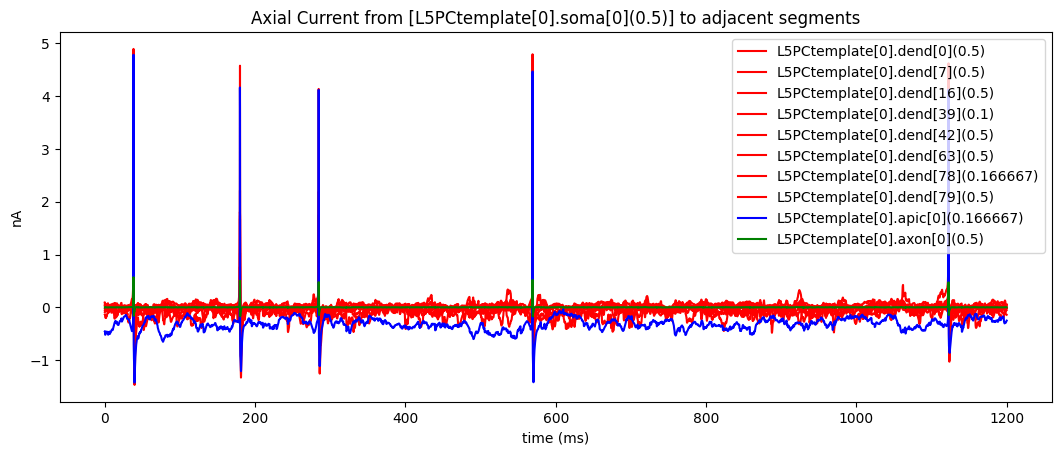

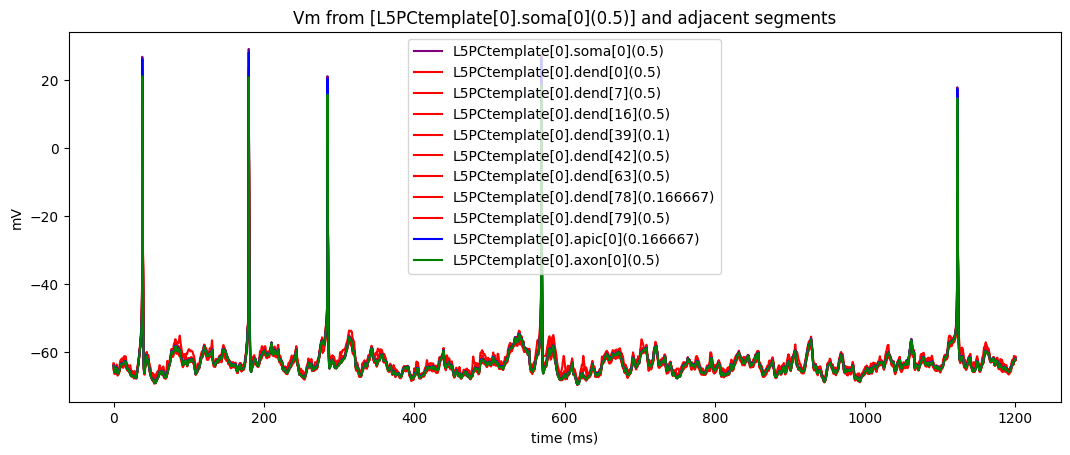

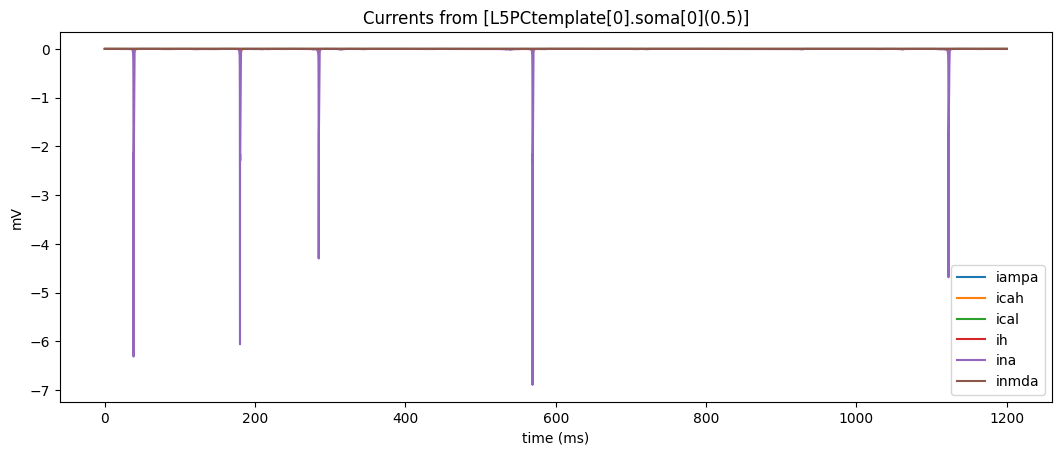

In [19]:
for seg in soma_segs:
    plot_all(seg)

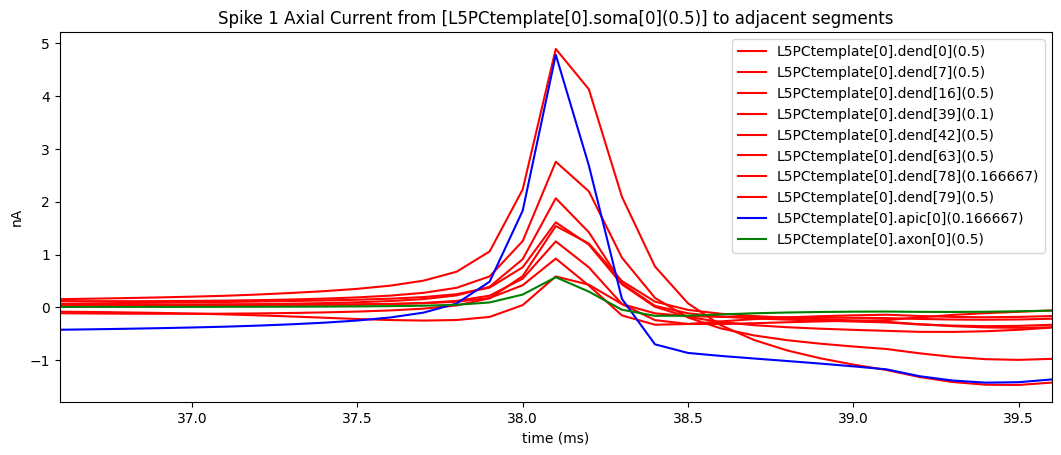

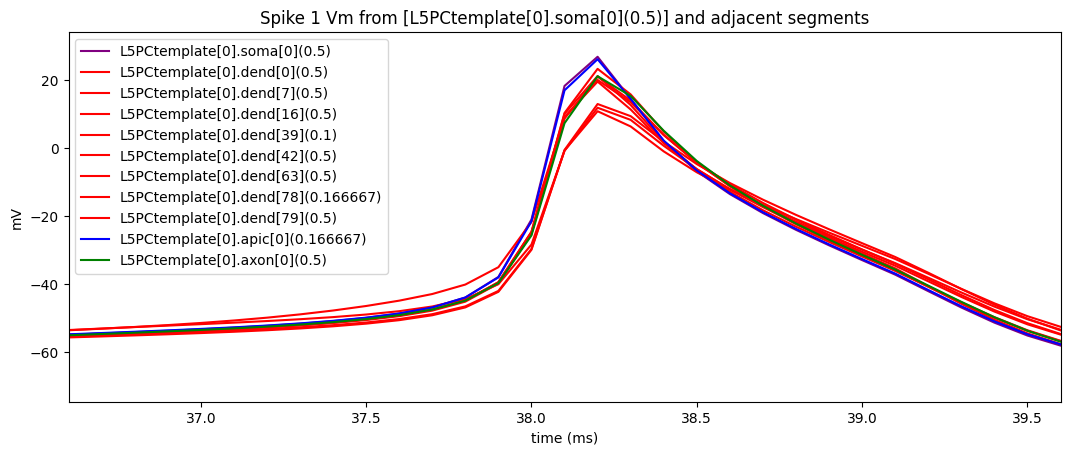

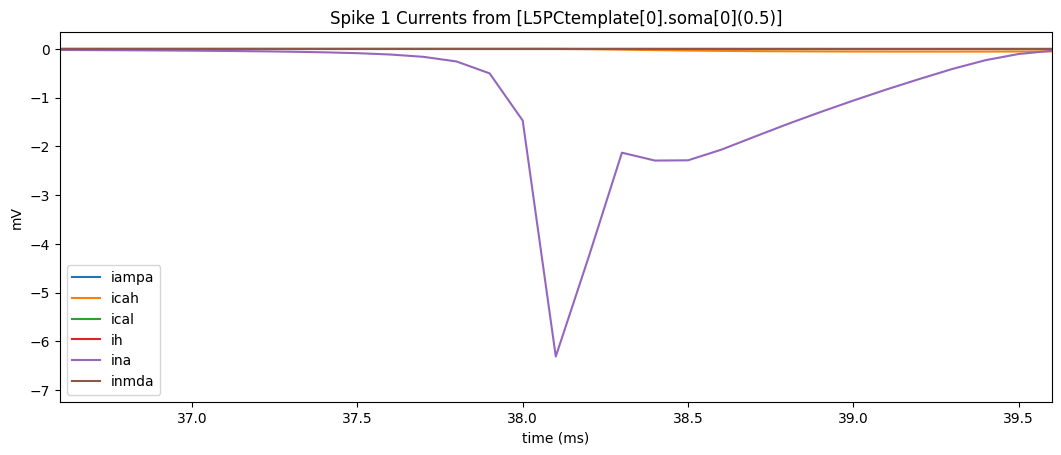

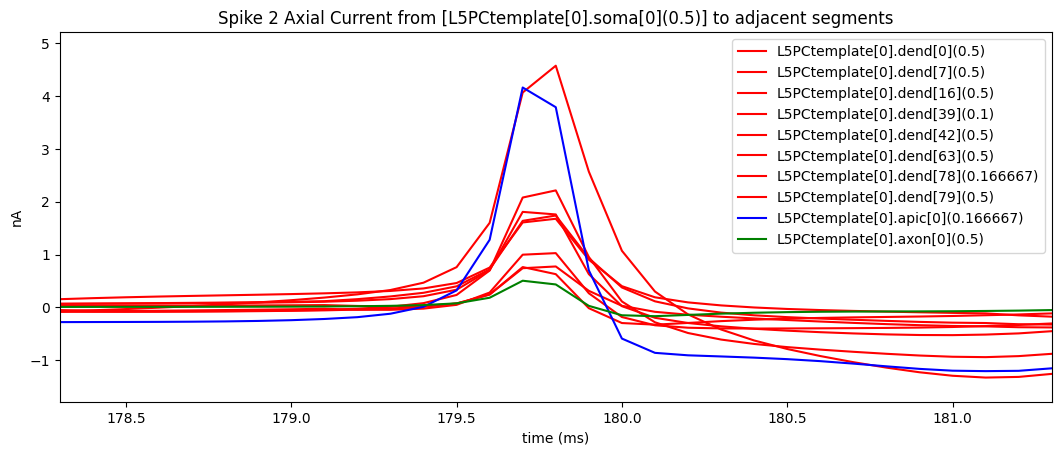

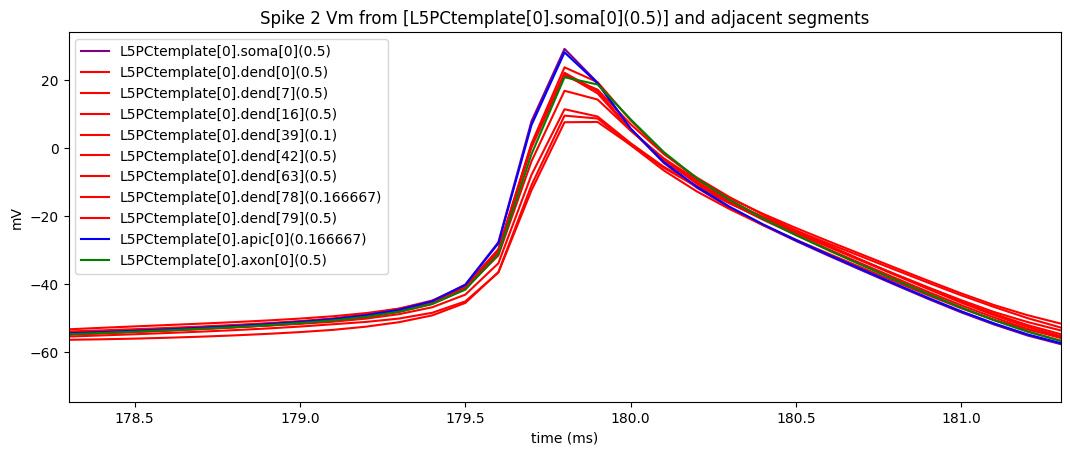

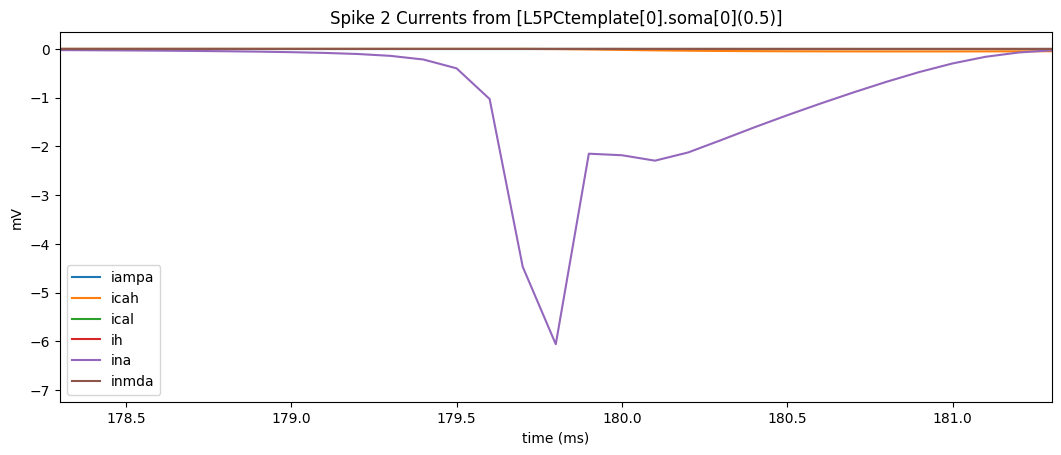

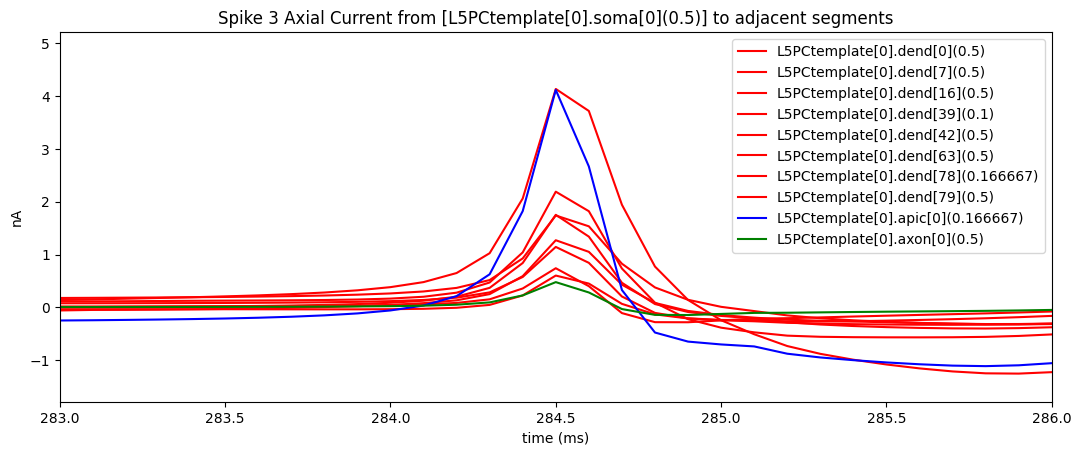

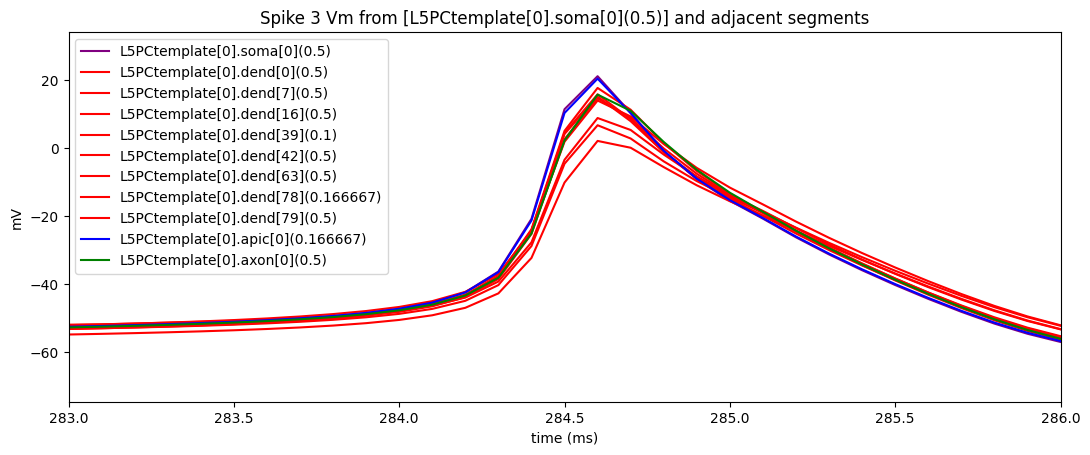

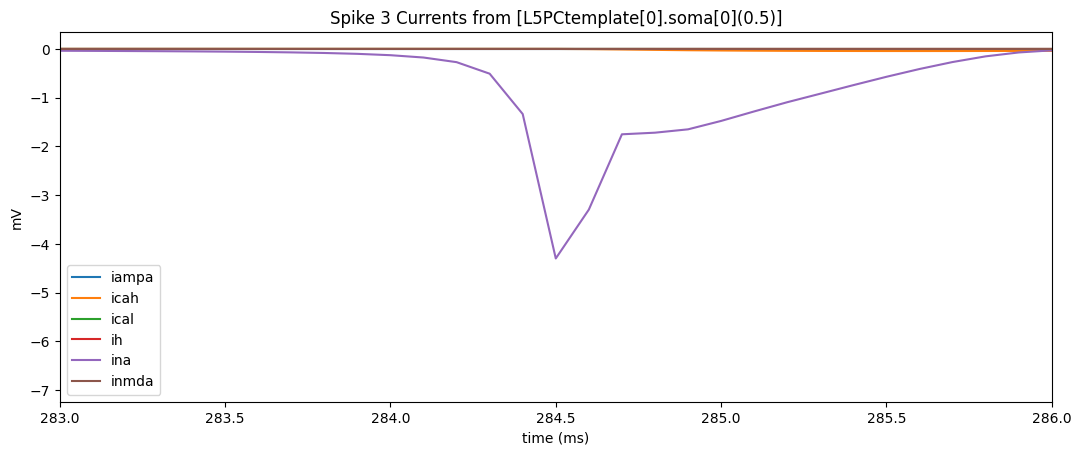

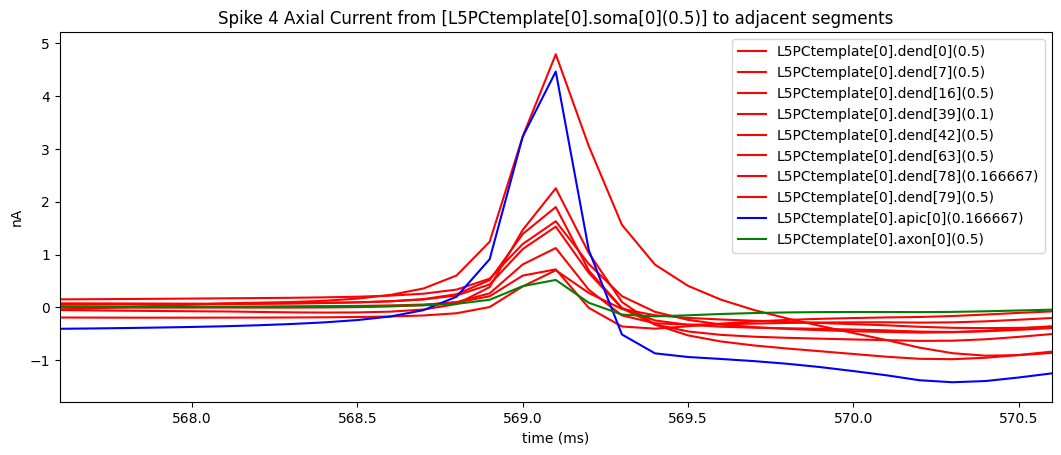

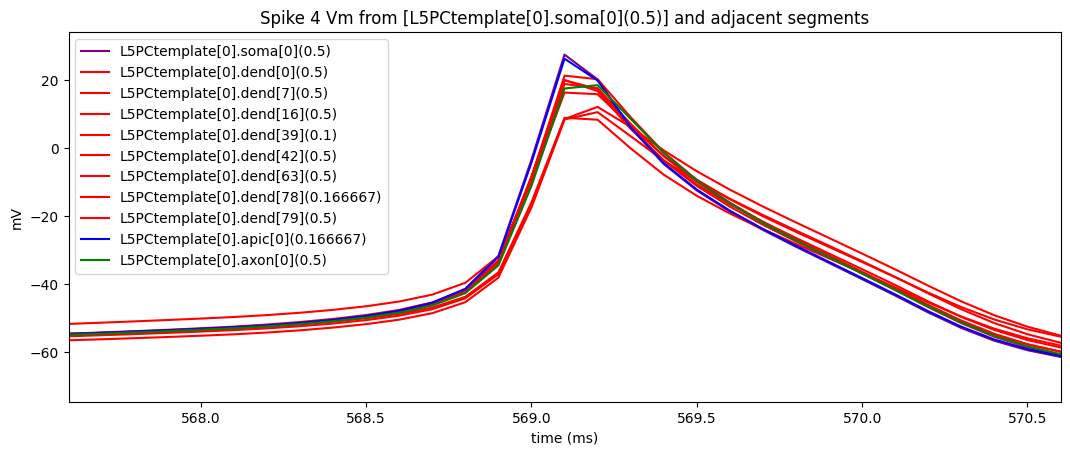

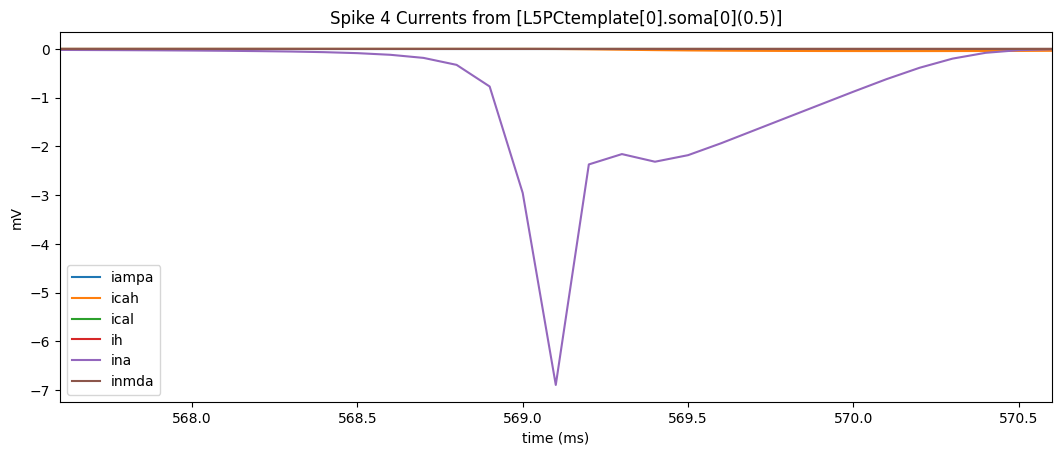

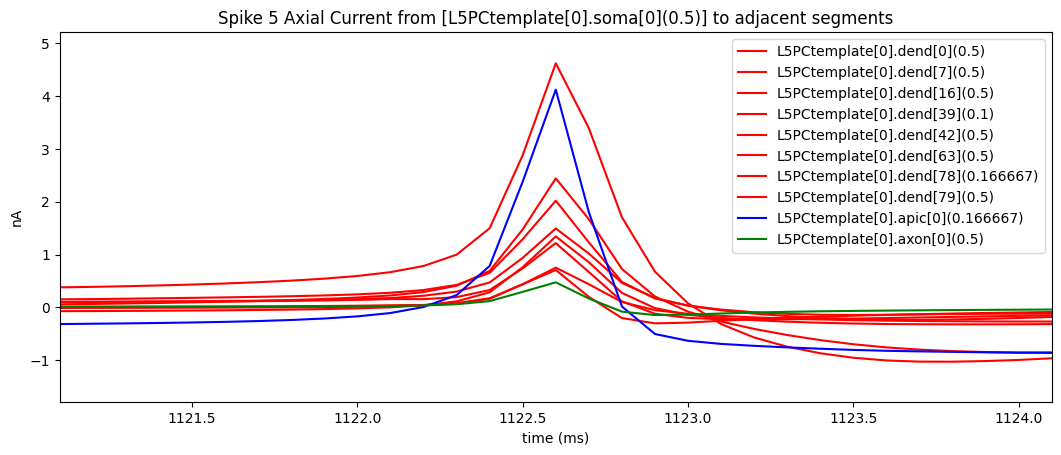

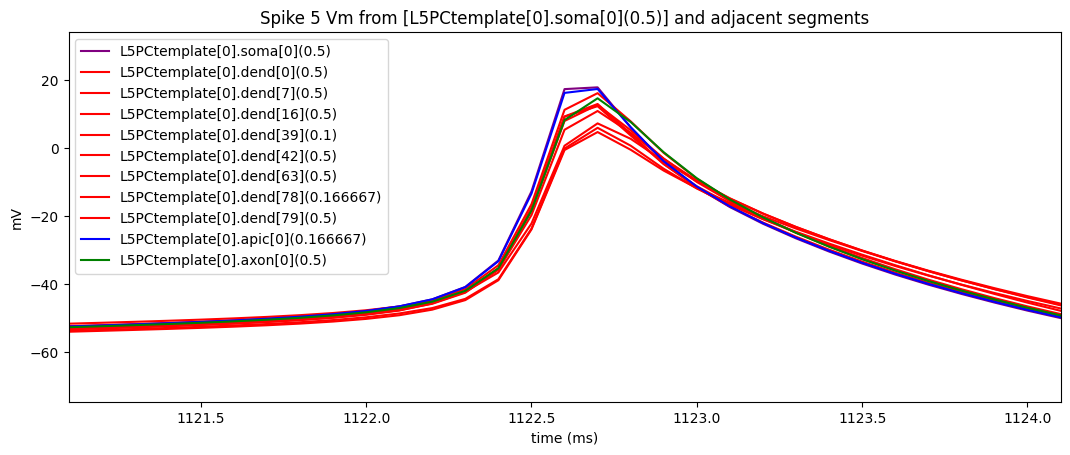

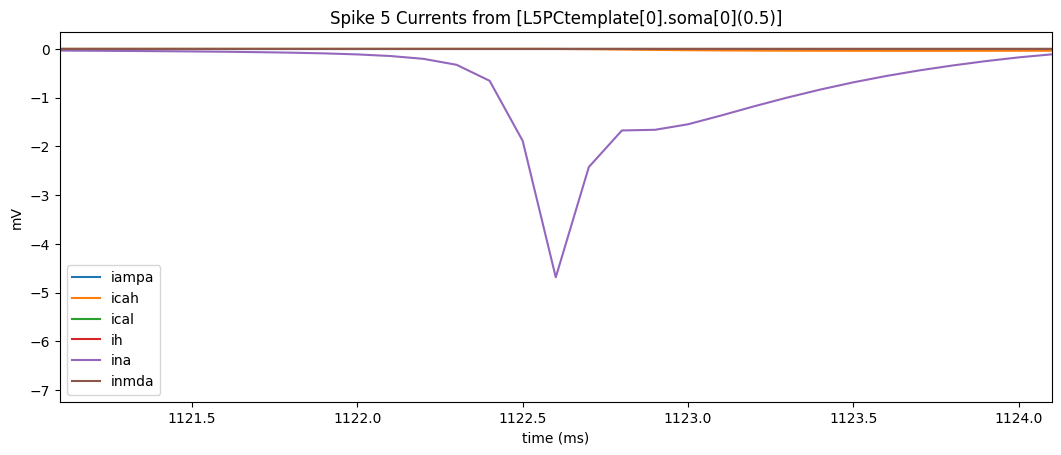

In [15]:
t=np.arange(0,len(sm.segments[0].v)*0.1,0.1)
for i,AP_time in enumerate(np.array(sm.soma_spiketimes)):# spike time (ms) #TODO: check
    before_AP = AP_time - 1.5 #0.5 # ms
    after_AP = AP_time + 1.5 #3 # ms
    xlim = [before_AP, after_AP] # time range

    # plot around each AP
    for seg in soma_segs:
        plot_all(seg, xlim=xlim, index=i+1)